In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
np.random.seed(42)
%matplotlib inline

In [2]:
data_dir = '/Users/mbedell/python/pmodes/experiments/data/'
import utils

In [3]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
xs_all = np.copy(d['xs'])

In [4]:
time_per_night = 45. * 60. # seconds
nights_per_year = 60

#### observe for N consecutive 1-min integrations every night

In [5]:
start_ts = np.arange(30,30+nights_per_year) * 3600. * 24. # nightly on consecutive nights
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [6]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 0.5

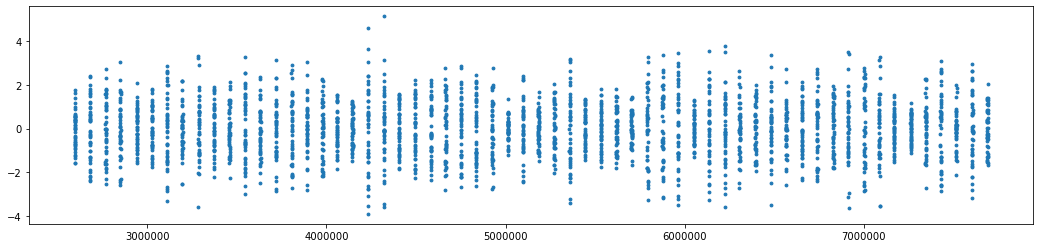

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t, y, s=8);

In [8]:
t_grid = np.ravel([np.linspace(t - 120, t + time_per_night + 60, 100) for t in start_ts]) # fine grid around the observed times

In [9]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(y)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
57it [00:00, 120.13it/s, logp=-2.301130e+03]
message: Optimization terminated successfully.
logp: -2632.2044446513783 -> -2301.13039905005


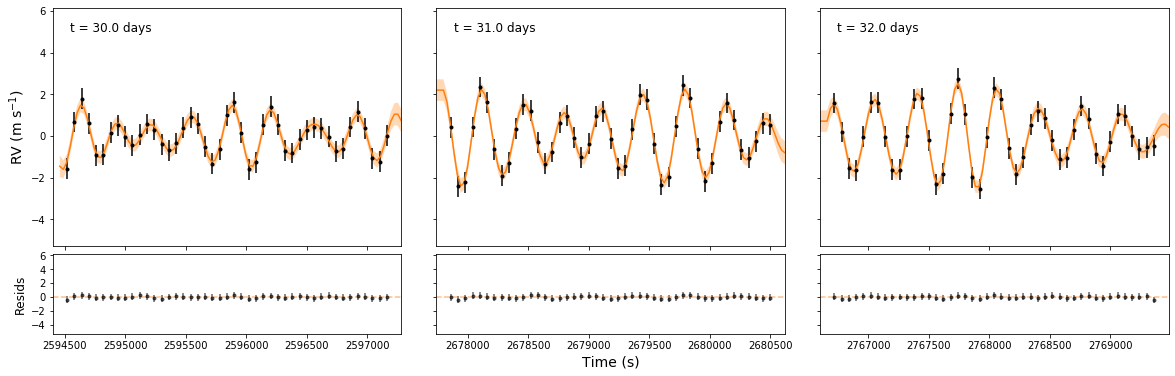

In [10]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd, time_per_night=time_per_night)

In [11]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.15 m/s


#### N consecutive observations per night, but random nights

In [12]:
start_ts = np.random.choice(360, nights_per_year, replace=False) * 3600. * 24. # nightly for random nights (we're gonna ignore seasons)
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts.sort()
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [13]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 0.5

In [14]:
t_grid = np.ravel([np.linspace(t - 120, t + time_per_night + 60, 100) for t in start_ts]) # fine grid around the observed times
t_grid = np.append(t_grid, np.linspace(t.min(), t.max(), 500)) # coarser grid for in between nights
t_grid.sort()

In [15]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(y)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
82it [00:00, 87.65it/s, logp=-2.281205e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: -2733.096624137242 -> -2281.2051012265783


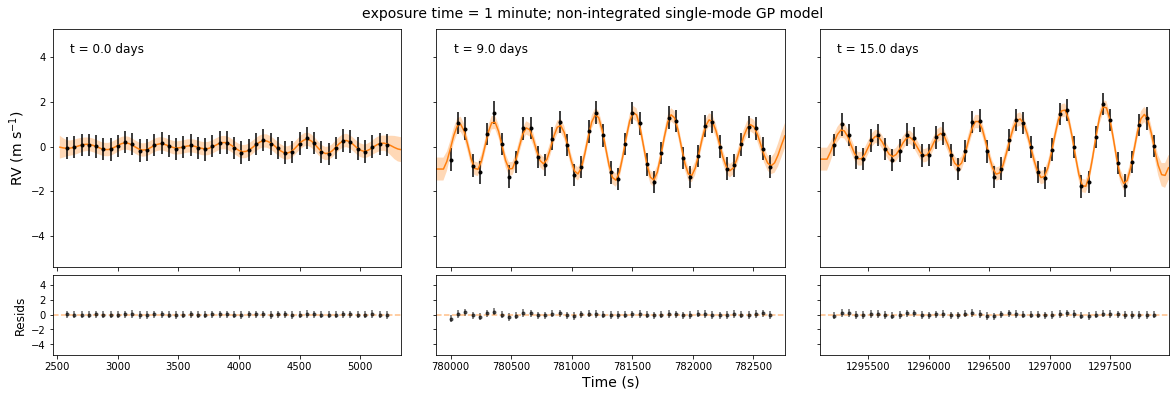

In [16]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd, time_per_night=time_per_night)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated.png');

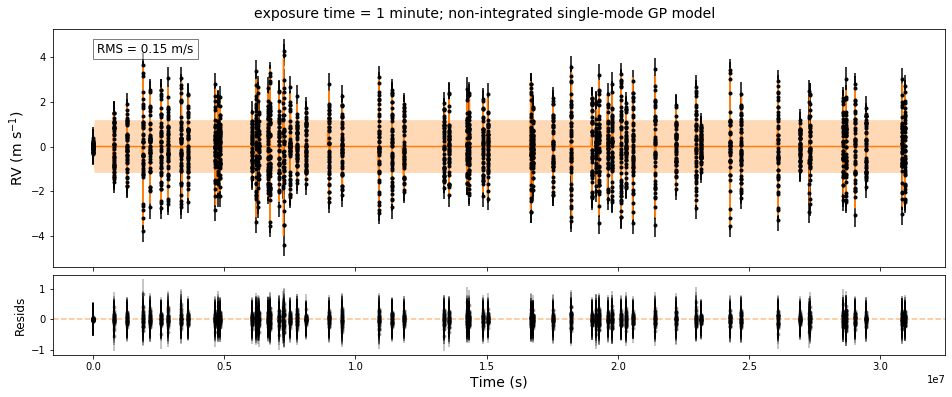

In [17]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated_full.png');

#### random nights, longer exposures

In [18]:
exp_time = 3. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)

t = []
y = []

for st in start_ts:
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        inds = (ts_all > stt - time_per_night - 1800.) & (ts_all < stt + time_per_night + 1800.)
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], st, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)
yerr = np.zeros_like(t) + 0.5

In [19]:
t_grid = np.ravel([np.linspace(t - 120, t + time_per_night + 60, 100) for t in start_ts]) # fine grid around the observed times
t_grid = np.append(t_grid, np.linspace(t.min(), t.max(), 500)) # coarser grid for in between nights
t_grid.sort()

In [20]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(y)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
42it [00:00, 794.93it/s, logp=-9.629872e+02]
message: Optimization terminated successfully.
logp: -1407.3666079404284 -> -962.9871605589018


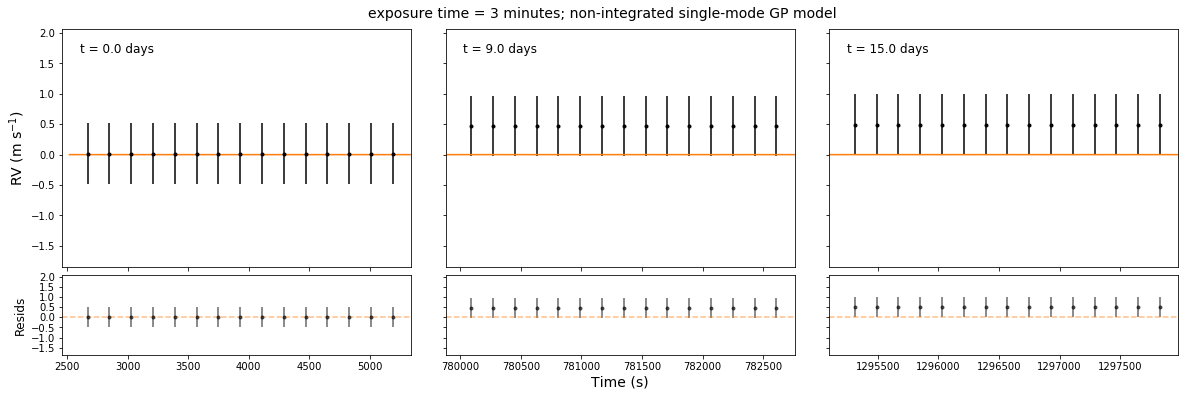

In [21]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd, time_per_night=time_per_night)
fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14);
#fig.savefig('randomnights_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

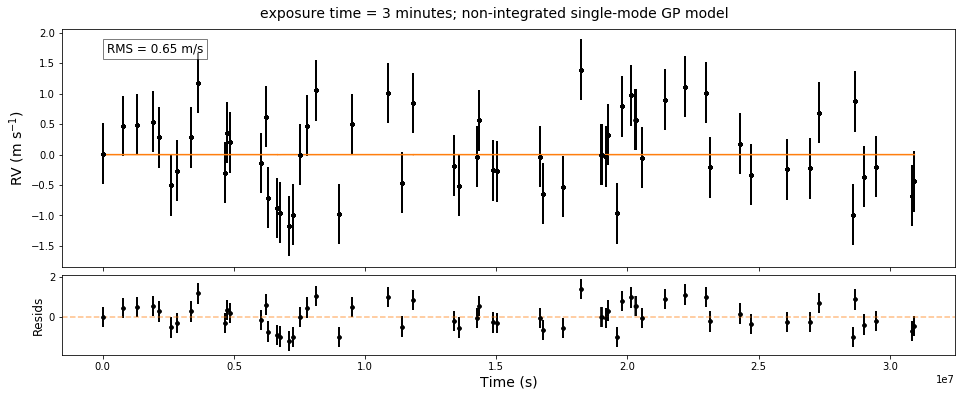

In [22]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14);
#fig.savefig('randomnights_{0:.0f}min_nonintegrated_full.png'.format(exp_time/60.));